
We will build an ML model for classifying speakers in a wav file, we need to extract relevant features from the audio data. These features will capture the unique characteristics of different speakers' voices:

## Features

### Pitch (Fundamental Frequency):

- **Why:** The pitch of a speaker's voice is a distinguishing feature. Although pitch alone might not be sufficient to distinguish between all speakers, it contributes to the overall feature set, especially when combined with other features.
- **How:** Pitch can be estimated using algorithms such as the autocorrelation method or the cepstrum method.

### Formants (Formant Frequencies):

- **Why:** Formants are the resonant frequencies of the vocal tract and are unique to each speaker. They provide information about the speaker's vocal tract shape and configuration.
- **How:** Formant frequencies can be extracted using linear predictive coding (LPC) or other spectral analysis methods.

### Zero-Crossing Rate (ZCR):

- **Why:** This feature measures the rate at which the signal changes sign. It provides information about the noisiness and texture of the sound, which can vary between speakers.
- **How:** Calculated by counting the number of times the signal crosses the zero amplitude axis.

### Mel-Frequency Cepstral Coefficients (MFCCs):

- **Why:** MFCCs are derived from the power spectrum of the audio signal and represent the short-term power spectrum of sound. They are widely used in speech and speaker recognition because they mimic the human auditory system's response, capturing the timbral aspects of audio which are essential for distinguishing different speakers.
- **How:** Extracting MFCCs involves computing the Fourier transform of the signal, mapping the powers of the spectrum onto the mel scale, and then taking the logarithm and applying the discrete cosine transform (DCT).

### Delta and Delta-Delta MFCCs:

- **Why:** These features capture the temporal dynamics of the speech signal, representing the rate of change (delta) and acceleration (delta-delta) of MFCC coefficients. They add information about how the speech characteristics change over time, which is valuable for distinguishing speakers based on their speaking style and rhythm.

- **How:** Delta MFCCs are computed as the difference between MFCCs at consecutive time steps, and delta-delta MFCCs are computed as the difference between delta MFCCs at consecutive time steps.

### Spectral Centroid: Represents the "center of mass" of the spectrum. It correlates with the perceived brightness of a sound.
- **Why:** Different speakers might have different spectral characteristics.
- **How**: Calculated as the weighted mean of the frequencies present in the signal, with their magnitudes as weights.


### Spectral Roll-off: The frequency below which a certain percentage of the total spectral energy lies.

- **Why:** Helps distinguish between speakers with different speaking tones and styles.
- **How:** Computed as the frequency below which a specified percentage (typically 85%) of the total spectral energy is contained.


# Preprocessing:

First we read the wav file and normalize the audio signal to have zero mean and unit variance.

In [1]:
import librosa
import numpy as np

raw, sr = librosa.load("data/speak/sample4_sveriges_radio-ok_boomer_20221207_0924400151.wav")

In [2]:
sr

22050

In [3]:
raw.mean(), raw.std()

(-0.00075107696, 0.097691804)

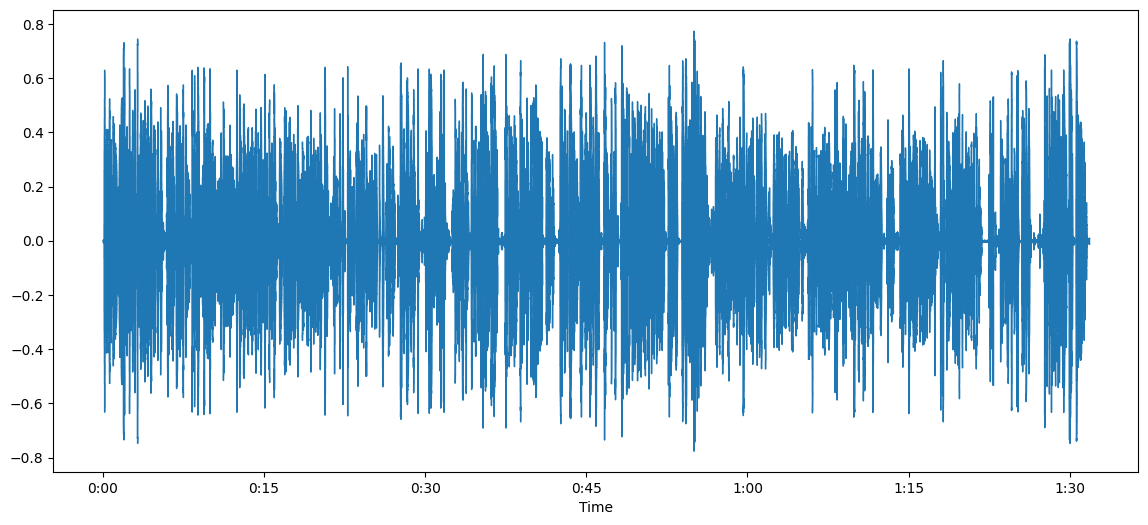

In [4]:
import matplotlib.pyplot as plt
# librosa.display.waveshow(y=raw[50_000:400_000], sr=sr)
plt.figure(figsize=(14, 6))
librosa.display.waveshow(y=raw, sr=sr)

In [5]:
normalized = (raw - np.mean(raw)) / np.std(raw)

In [6]:
normalized.mean(), normalized.std()

(2.1334574e-09, 1.0)

We divide the audio into short overlapping frames. This helps capture the temporal structure of the audio, which is essential for extracting meaningful features.

A common approach[citation_needed] is to use a frame length of 25ms and a hop length of 10ms.

This means each frame is 25ms long, and the start of each frame is 10ms after the start of the previous frame, resulting in overlapping frames.

In [7]:
def segment_audio(audio, sample_rate, frame_length=0.025, hop_length=0.01):

    # Convert frame length and hop length from seconds to samples
    frame_length_samples = int(sample_rate * frame_length)
    hop_length_samples = int(sample_rate * hop_length)
    
    # Frame the audio
    frames = librosa.util.frame(audio, frame_length=frame_length_samples, hop_length=hop_length_samples).T
    
    return frames

frames = segment_audio(normalized, sr)

In [8]:
frames.shape

(9198, 551)

# Feature Extraction:

### Get MFCCs for each frame.
- Calculate delta and delta-delta MFCCs.

In [9]:
def get_mfccs(audio, sample_rate, n_mfcc=13, frame_length=0.025, hop_length=0.01):
    # Convert frame length and hop length from seconds to samples
    frame_length_samples = int(sample_rate * frame_length)
    hop_length_samples = int(sample_rate * hop_length)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc, 
                                 n_fft=frame_length_samples, hop_length=hop_length_samples)

    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)

    return mfccs.T, delta_mfccs.T, delta2_mfccs.T

mfccs, mfccs_delta, mfccs_delta2 = get_mfccs(normalized, sr)

In [10]:
mfccs.shape, mfccs_delta.shape, mfccs_delta2.shape

((9201, 13), (9201, 13), (9201, 13))

### Estimate pitch frequencies each frame

In general, the fundamental frequency of the complex speech tone – also known as the pitch or f0 – lies in the range of 100-120 Hz for men, but variations outside this range can occur. The f0 for women is found approximately one octave higher. For children, f0 is around 300 Hz.

In [11]:
def estimate_pitch(audio, sample_rate, frame_length=0.025, hop_length=0.01):
    hop_length_samples = int(sample_rate * hop_length)
    pitches, voiced_flag, voiced_probs = librosa.pyin(audio, 
                                                      fmin=librosa.note_to_hz('C2'), 
                                                      fmax=librosa.note_to_hz('C5'), 
                                                      hop_length=hop_length_samples)
    return pitches, voiced_flag, voiced_probs


pitches, voiced_flag, voiced_probs = estimate_pitch(normalized, sr)

In [12]:
pitches.shape

(9201,)

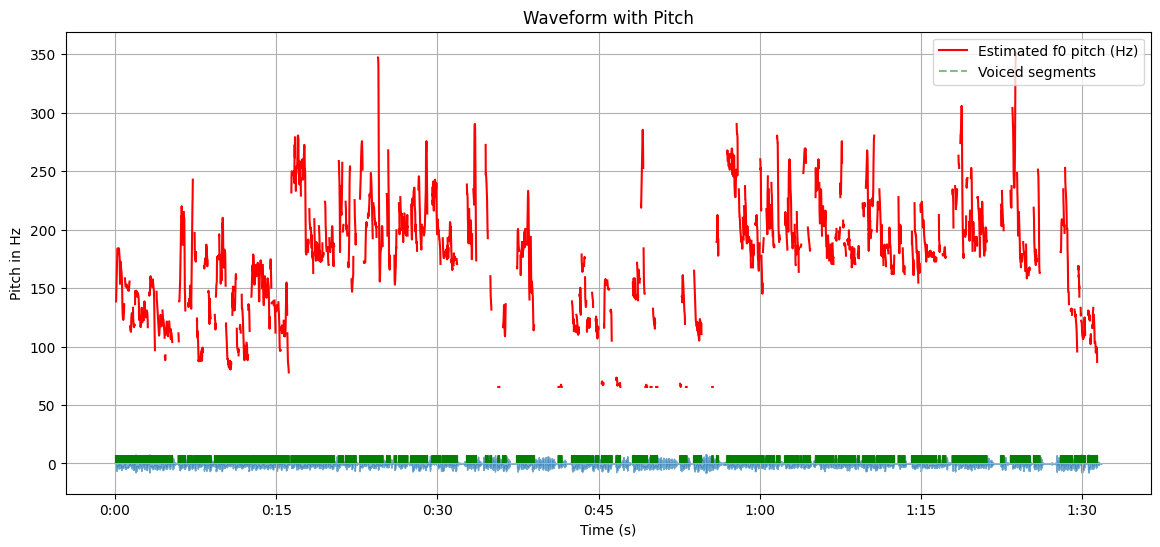

In [13]:
import matplotlib.pyplot as plt

hop_length = 0.01
hop_length_samples = int(sr * hop_length) # Convert the hop length to time axis

times = librosa.times_like(pitches, sr=sr, hop_length=hop_length_samples)

plt.figure(figsize=(14, 6))
librosa.display.waveshow(normalized, sr=sr, alpha=0.6)

plt.plot(times, pitches, label='Estimated f0 pitch (Hz)', color='r')

# Highlight voiced segments
plt.vlines(times[voiced_flag], 0, np.max(normalized), color='g', alpha=0.5, linestyle='--', label='Voiced segments')

plt.xlabel('Time (s)')
plt.ylabel('Pitch in Hz')
plt.title('Waveform with Pitch')
plt.legend(loc="upper right")
plt.grid()

plt.show()

In [14]:
# Fill nan with the last seen value

def forward_fill(data):
    for i in range(1, len(data)):
        if np.isnan(data[i]) and not np.isnan(data[i - 1]):
            data[i] = data[i - 1]

    return data

# Might want to experiment with other methods to replace nan

In [15]:
filled_pitches = forward_fill(pitches)

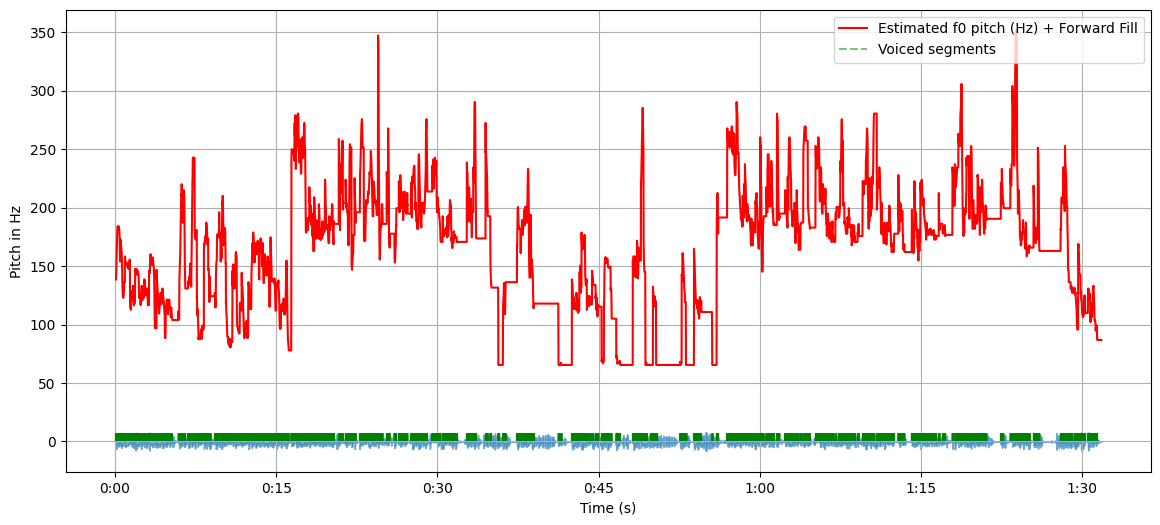

In [16]:
plt.figure(figsize=(14, 6))
librosa.display.waveshow(normalized, sr=sr, alpha=0.6)
plt.plot(times, filled_pitches, label='Estimated f0 pitch (Hz) + Forward Fill', color='r')
plt.vlines(times[voiced_flag], 0, np.max(normalized), color='g', alpha=0.5, linestyle='--', label='Voiced segments')
plt.xlabel('Time (s)')
plt.ylabel('Pitch in Hz')
plt.legend(loc="upper right")
plt.grid()
plt.show()

A simple forward fill is one of many solutions to missing pitch data. Pauses are useful for determining who is speaking, we should use voiced_flags with windows to remove longer durations of forward fills

([<matplotlib.lines.Line2D at 0x134e02690>], 9201)

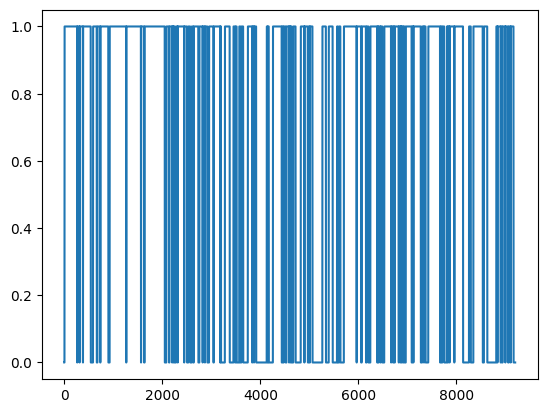

In [17]:
def bridge_voiced_flags(voiced_flag, sample_rate, ms):
    x_samples = int(sample_rate * (ms / 1000))
    return np.where(np.convolve(voiced_flag, np.ones(x_samples), mode='same') >= 1, True, voiced_flag) # Find better function

bridged_voiced_flag=bridge_voiced_flags(voiced_flag, sr, 0.5)

plt.plot(bridged_voiced_flag), len(bridged_voiced_flag)

In [18]:
def mask_silence(arr, mask, target_val):
    a = arr.copy()
    a[~mask] = target_val
    return a

pitch_featue = mask_silence(filled_pitches, bridged_voiced_flag, -1.0)

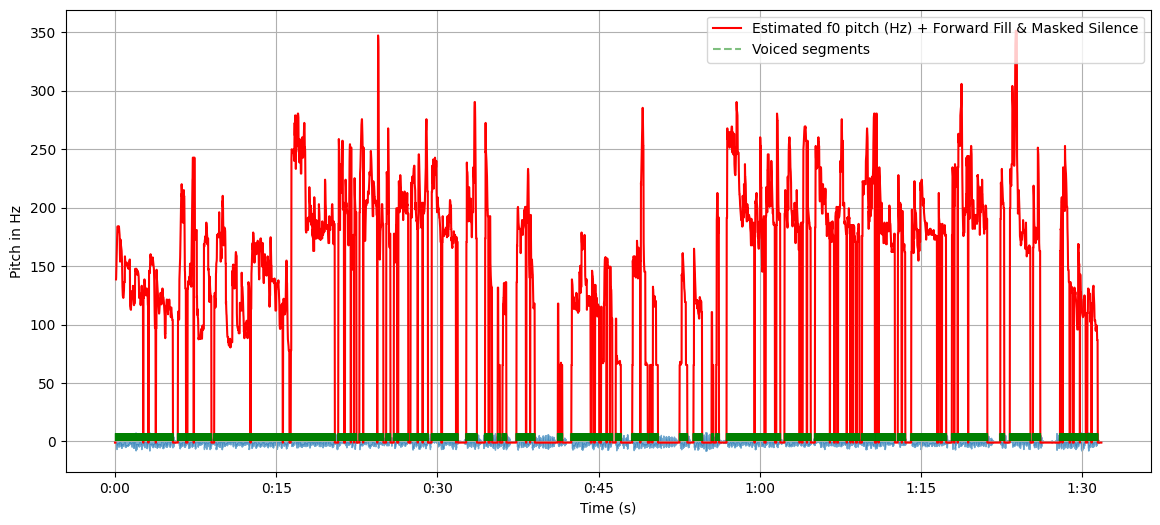

In [19]:
plt.figure(figsize=(14, 6))
librosa.display.waveshow(normalized, sr=sr, alpha=0.6)
plt.plot(times, pitch_featue, label='Estimated f0 pitch (Hz) + Forward Fill & Masked Silence', color='r')
plt.vlines(times[bridged_voiced_flag], 0, np.max(normalized), color='g', alpha=0.5, linestyle='--', label='Voiced segments')
plt.xlabel('Time (s)')
plt.ylabel('Pitch in Hz')
plt.legend(loc="upper right")
plt.grid()
plt.show()

### Estimate formant frequencies for each frame.

In [20]:
def estimate_formants(audio, sample_rate, frame_length=0.025, hop_length=0.01, n_formants=5):
    frame_length_samples = int(sample_rate * frame_length)
    hop_length_samples = int(sample_rate * hop_length)
    num_frames = (len(audio) - frame_length_samples) // hop_length_samples + 1
    
    formants = np.zeros((num_frames, n_formants))

    for i, frame in enumerate(librosa.util.frame(audio, frame_length=frame_length_samples, hop_length=hop_length_samples).T):

        lpc_coeffs = librosa.lpc(frame, order=2 + sample_rate // 1000)

        roots = np.roots(lpc_coeffs)
        roots = roots[np.imag(roots) >= 0]
        angz = np.arctan2(np.imag(roots), np.real(roots))
        freqs = angz * (sample_rate / (2 * np.pi))
        freqs = np.sort(freqs)
        formants[i, :min(n_formants, len(freqs))] = freqs[:n_formants]

    return formants

formants = estimate_formants(normalized, sr)

In [21]:
def estimate_formants(audio, sample_rate, frame_length=0.025, hop_length=0.01, n_formants=5):
    frame_length_samples = int(sample_rate * frame_length)
    hop_length_samples = int(sample_rate * hop_length)
    
    # Use librosa to generate frames
    frames = librosa.util.frame(audio, frame_length=frame_length_samples, hop_length=hop_length_samples)
    num_frames = frames.shape[1]
    
    formants = np.zeros((num_frames, n_formants))

    for i, frame in enumerate(frames.T):
        lpc_coeffs = librosa.lpc(frame, order=2 + sample_rate // 1000)
        roots = np.roots(lpc_coeffs)
        roots = roots[np.imag(roots) >= 0]
        angz = np.arctan2(np.imag(roots), np.real(roots))
        freqs = angz * (sample_rate / (2 * np.pi))
        freqs = np.sort(freqs)
        formants[i, :min(n_formants, len(freqs))] = freqs[:n_formants]

    return formants

In [22]:
formants = estimate_formants(normalized, sr)

Formants are resonant frequencies of the vocal tract. They are important in distinguishing different vowels and are key in speech processing and phonetics. Typically, the first two or three formants (F1, F2, F3) are most important for vowel identification:

- F1 is related to the height of the tongue (high vs. low vowels).
- F2 is related to the frontness or backness of the tongue (front vs. back vowels).
- F3 provides additional phonetic information, often related to the rounding of the lips.


Pre-emphasis is often applied to balance the frequency spectrum.

Other methods for formants and smoothing:

In [23]:
from scipy.signal import lfilter
from scipy.signal.windows import hamming

order = 12
lpc_coeffs = []
for frame in frames:
    a = librosa.lpc(y=frame, order=order)
    lpc_coeffs.append(a)

In [24]:
formants3 = []
for coeffs in lpc_coeffs:
    roots = np.roots(coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]
    angles = np.angle(roots)
    formants3.append(sorted(angles * (sr / (2 * np.pi))))


In [25]:
def get_formants(lpc_coeffs, sr):
    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]
    angles = np.angle(roots)
    frequencies = sorted(angles * (sr / (2 * np.pi)))
    return frequencies[:3]

formants4 = np.array([get_formants(coeffs, sr) for coeffs in lpc_coeffs])

In [26]:
formants4.shape

(9198, 3)

In [27]:
def smooth_formants(formants, window_size=10):
    f1_smooth = np.convolve(formants[:, 0], np.ones(window_size)/window_size, mode='valid')
    f2_smooth = np.convolve(formants[:, 1], np.ones(window_size)/window_size, mode='valid')
    return f1_smooth, f2_smooth

f1_smooth, f2_smooth = smooth_formants(formants4)

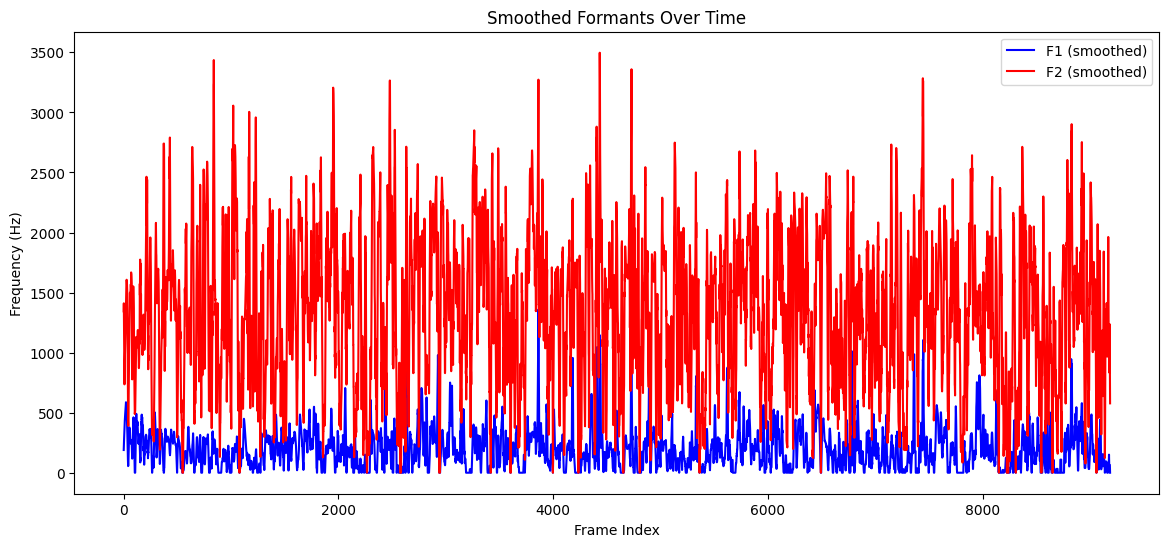

In [59]:
plt.figure(figsize=(14, 6))
plt.plot(f1_smooth, label='F1 (smoothed)', color='b')
plt.plot(f2_smooth, label='F2 (smoothed)', color='r')
plt.xlabel('Frame Index')
plt.ylabel('Frequency (Hz)')
plt.title('Smoothed Formants Over Time')
plt.legend()
plt.show()


### Calculate Zero-crossing rate for each frame.

In [29]:
def calculate_zcr(audio, sample_rate, frame_length=0.025, hop_length=0.01):
    frame_length_samples = int(sample_rate * frame_length)
    hop_length_samples = int(sample_rate * hop_length)

    zcr = librosa.feature.zero_crossing_rate(y=audio, frame_length=frame_length_samples, hop_length=hop_length_samples)[0]

    return zcr.T

zcr = calculate_zcr(normalized, sr)

In [30]:
zcr.shape

(9201,)

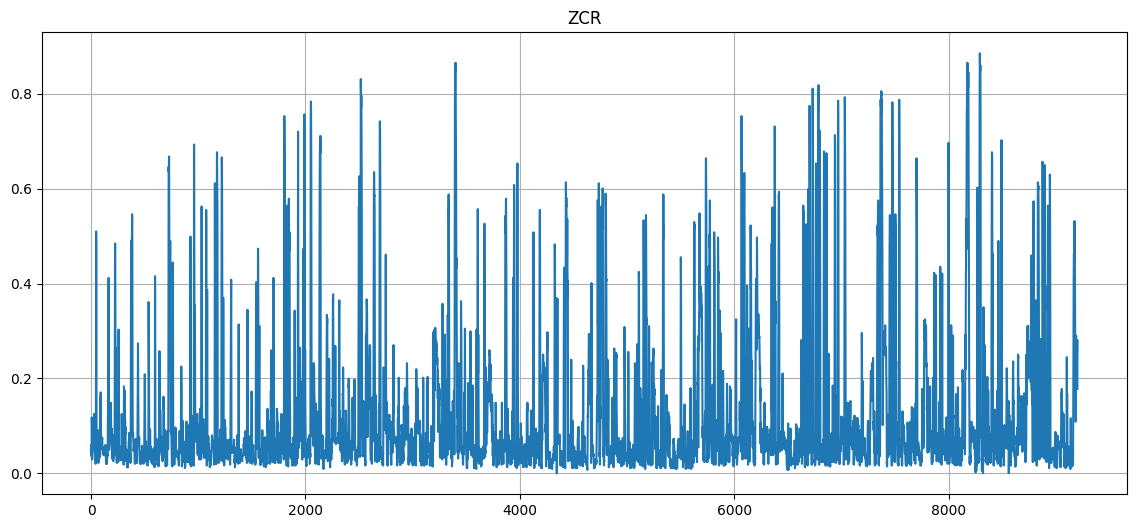

In [63]:
plt.figure(figsize=(14, 6))
plt.plot(zcr)
plt.title('ZCR')
plt.grid()

Zero crossing rate is the rate at which the audio signal changes sign. 

In [32]:
pitch2_normalized = np.nan_to_num(pitch_featue, nan=-1.0)
pitch2_normalized = (pitch2_normalized-np.min(pitch2_normalized))/(np.max(pitch2_normalized)-np.min(pitch2_normalized))

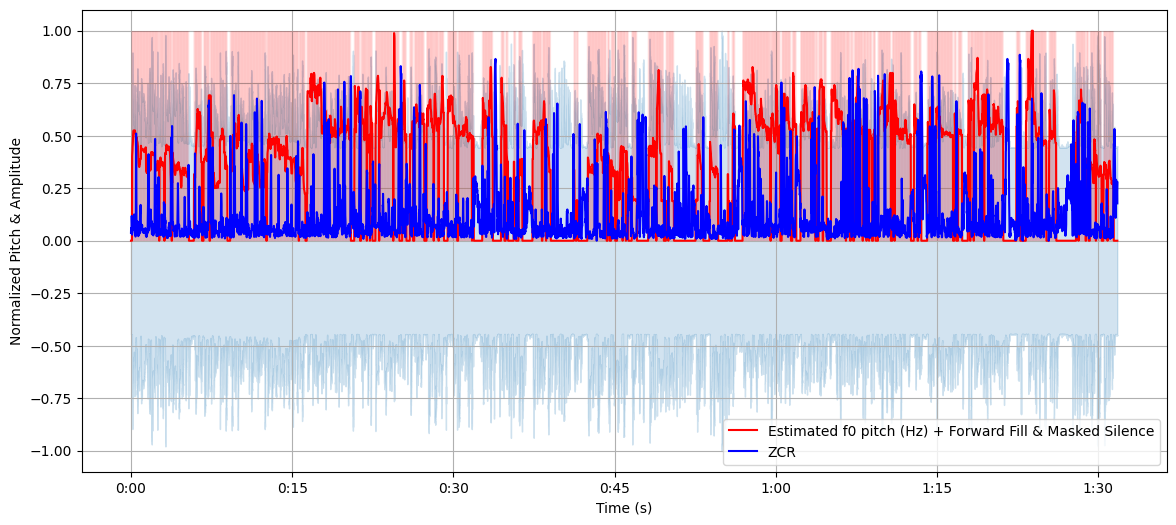

In [72]:
plt.figure(figsize=(14, 6))
librosa.display.waveshow((normalized-np.min(normalized))/(np.max(normalized)-np.min(normalized)), sr=sr, alpha=0.2)
plt.plot(times, pitch2_normalized, label='Estimated f0 pitch (Hz) + Forward Fill & Masked Silence', color='r')
plt.vlines(times[bridged_voiced_flag], 0, 1, color='r', alpha=0.01, linestyle='-')
plt.plot(times, zcr, label='ZCR', color='b')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Pitch & Amplitude')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### Calculate spectral features (centroid, roll-off).

In [34]:
def calculate_sc(audio, sample_rate, frame_length=0.025, hop_length=0.01):
    frame_length_samples = int(sample_rate * frame_length)
    hop_length_samples = int(sample_rate * hop_length)

    sc = librosa.feature.spectral_centroid(y=audio, n_fft=frame_length_samples, hop_length=hop_length_samples)[0]
    rolloff = librosa.feature.spectral_rolloff(y=audio, n_fft=frame_length_samples, hop_length=hop_length_samples)[0]

    return sc.T, rolloff.T

sc, rolloff = calculate_sc(normalized, sr)

In [35]:
sc.shape, rolloff.shape

((9201,), (9201,))

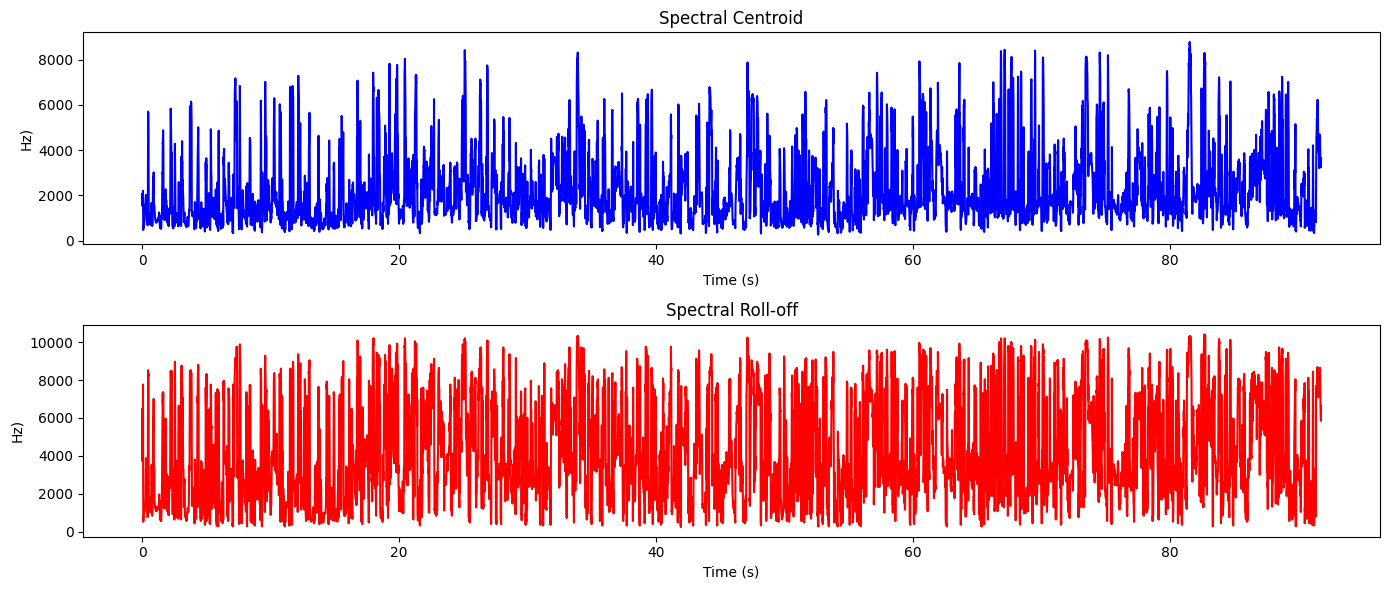

In [73]:

frames = range(len(sc))
t = librosa.frames_to_time(frames, sr=sr, hop_length=int(sr * 0.01))

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(t, sc, color='b')
plt.xlabel('Time (s)')
plt.ylabel('Hz)')
plt.title('Spectral Centroid')

plt.subplot(2, 1, 2)
plt.plot(t, rolloff, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Hz)')
plt.title('Spectral Roll-off')

plt.tight_layout()
plt.show()

# Feature Aggregation

In [37]:
# features = np.hstack((pitch[:, np.newaxis], mfccs, mfccs_delta, mfccs_delta2, zcr[:, np.newaxis]))

# print(features.shape)

In [38]:
features = {"MFCCs": mfccs,
            "Delta MFCCs": mfccs_delta,
            "Delta-Delta MFCCs": mfccs_delta2,
            "Pitch": pitch_featue[:, np.newaxis],
            "ZCR": zcr[:, np.newaxis],
            "Formants": formants,
            "Spectral Centroid": sc[:, np.newaxis],
            "Spectral Roll-off": rolloff[:, np.newaxis]
            }

In [39]:
max_name_len = max(len(name) for name in features.keys())

In [40]:
for name, val in features.items():
    print(f"{name:<{max_name_len}} : {val.shape}")

for name, val in features.items():
    if np.any(np.isnan(val)):
        print(f"\nNaN values present in the {name} array: ", end='')
        print(len(np.argwhere(np.isnan(val))))

        features.update({name:np.nan_to_num(val, nan=-1.0)})
        print(f"All NaN in {name} replaced with -1.0")

MFCCs             : (9201, 13)
Delta MFCCs       : (9201, 13)
Delta-Delta MFCCs : (9201, 13)
Pitch             : (9201, 1)
ZCR               : (9201, 1)
Formants          : (9198, 5)
Spectral Centroid : (9201, 1)
Spectral Roll-off : (9201, 1)

NaN values present in the Pitch array: 5
All NaN in Pitch replaced with -1.0


In [41]:
padded_formants = np.pad(formants[:, :formants.shape[1]], ((len(mfccs_delta) - len(formants), 0), (0, 0)), mode='constant', constant_values=0)
features.update({"Formants":padded_formants})

In [42]:
combined_features = np.hstack([i for i in features.values()])

combined_features.shape

(9201, 48)

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

# Model Architecture

# Vector Embeddings

In [44]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=48)
reduced_features = pca.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=10, random_state=42)
cluster_assignments = kmeans.fit_predict(reduced_features)

cluster_centroids = kmeans.cluster_centers_

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

features = combined_features

input_dim = features.shape[1]
encoding_dim = 49

def create_autoencoder(input_dim, encoding_dim):

    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(256, activation='relu')(input_layer)
    encoded = layers.Dense(128, activation='relu')(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

    decoded = layers.Dense(128, activation='relu')(encoded)
    decoded = layers.Dense(256, activation='relu')(decoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)

    return autoencoder, encoder

autoencoder, encoder = create_autoencoder(input_dim, encoding_dim)

autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(features, features, epochs=128, batch_size=128, shuffle=True, validation_split=0.2)

embeddings = encoder.predict(features)

print(embeddings.shape)


2024-05-24 16:10:23.815064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1029002.5000 - val_loss: 1245364.8750
Epoch 2/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1050913.3750 - val_loss: 1245364.8750
Epoch 3/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1036580.2500 - val_loss: 1245364.8750
Epoch 4/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1042715.9375 - val_loss: 1245364.8750
Epoch 5/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1058689.5000 - val_loss: 1245364.8750
Epoch 6/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1062444.1250 - val_loss: 1245364.8750
Epoch 7/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1062411.1250 - val_loss: 1245364.8750
Epoch 8/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1049720.2500 - val_loss: 1245364.8750
Epoch 9/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1029260.3125 - val_loss: 1245364.8750
Epoch 10/128
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1033566.8750 - val_loss: 1245364.8750
Epoch 11/128
58/58 ━━━━━━━━━━

In [46]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 49)             │         6,321 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 48)             │        12,336 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,565 (1.18 MB)

 Trainable params: 103,521 (404.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 207,044 (808.77 KB)

Number of clusters found: 4
Number of noise points: 3314


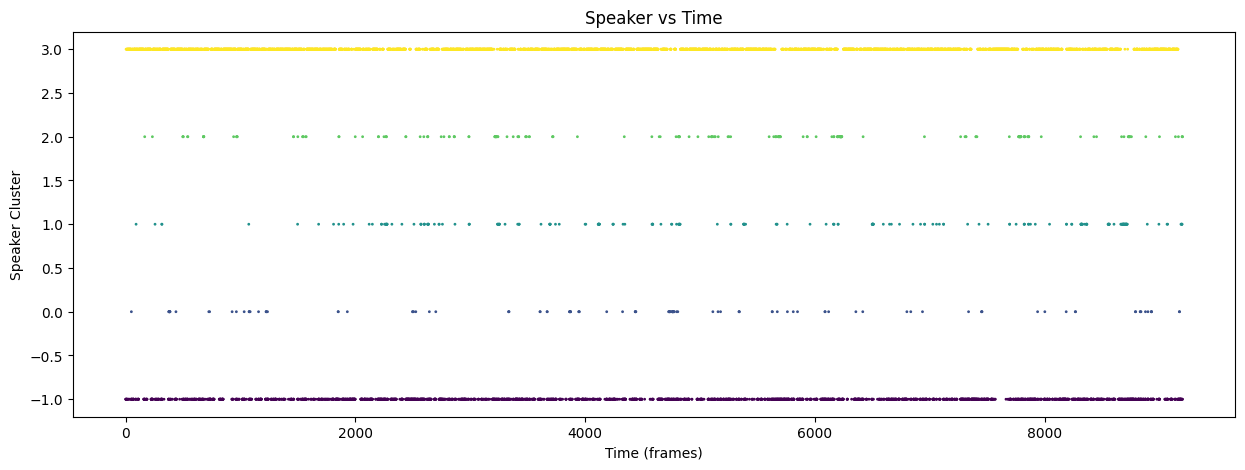

In [75]:
import hdbscan

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_samples=30, min_cluster_size=70)
cluster_labels = clusterer.fit_predict(embeddings)

# Number of clusters (excluding noise)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise = list(cluster_labels).count(-1)

print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise}")

plt.figure(figsize=(15, 5))
plt.scatter(range(len(cluster_labels)), cluster_labels, c=cluster_labels, s=1)
plt.title('Speaker vs Time')
plt.xlabel('Time (frames)')
plt.ylabel('Speaker Cluster')
plt.show()

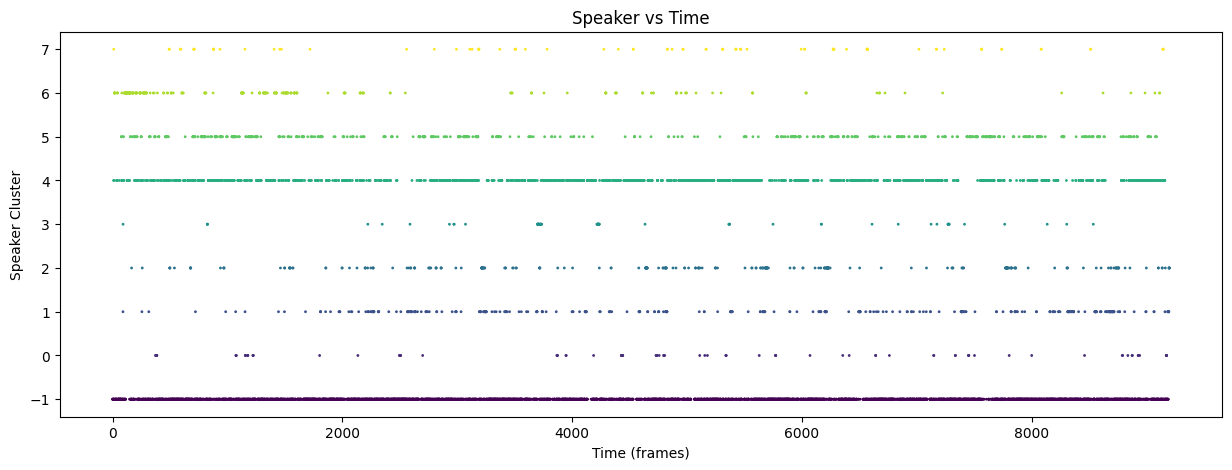

In [48]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(cluster_labels)), cluster_labels, c=cluster_labels, s=1)
plt.title('Speaker vs Time')
plt.xlabel('Time (frames)')
plt.ylabel('Speaker Cluster')
plt.show()

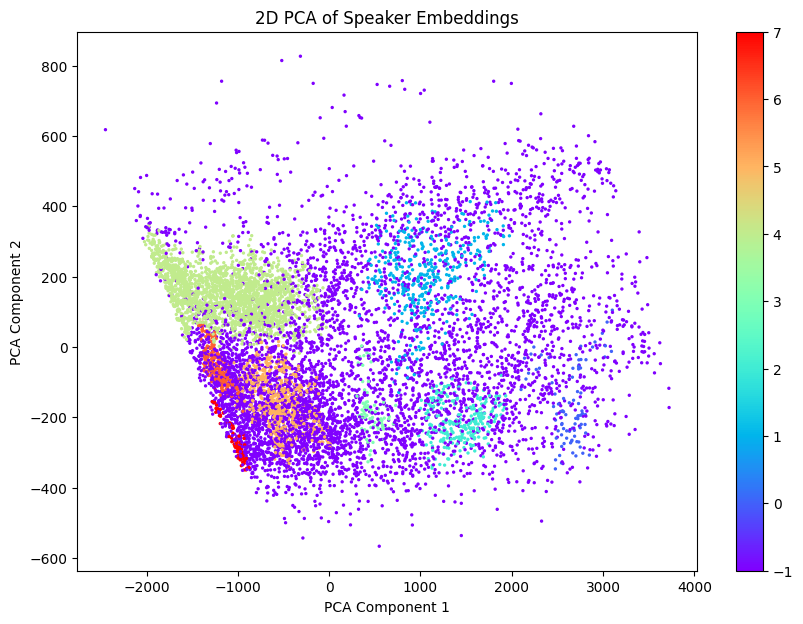

In [49]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='rainbow', s=2)
plt.title('2D PCA of Speaker Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import layers, models

scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_features)

pca = PCA(n_components=48)
reduced_features = pca.fit_transform(scaled_features)


def create_embedding_model(input_dim, embedding_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(embedding_dim, activation='linear')
    ])
    return model


embedding_model = create_embedding_model(reduced_features.shape[1], embedding_dim=48)


embedding_model.compile(optimizer='adam', loss='mse')

history = embedding_model.fit(reduced_features, reduced_features, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

speaker_embeddings = embedding_model.predict(reduced_features)

print("Embeddings shape:", speaker_embeddings.shape)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6138 - val_loss: 0.6395
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5976 - val_loss: 0.5169
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4182 - val_loss: 0.4363
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3397 - val_loss: 0.3637
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2922 - val_loss: 0.3026
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2588 - val_loss: 0.2518
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2344 - val_loss: 0.2104
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2176 - val_loss: 0.1758
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2009 - val_loss: 0.1516
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1897 - val_loss: 0.1304
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1789 - val_loss: 0.1150
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1695 - val_lo

Dlusters found: 3
Noise points: 8394


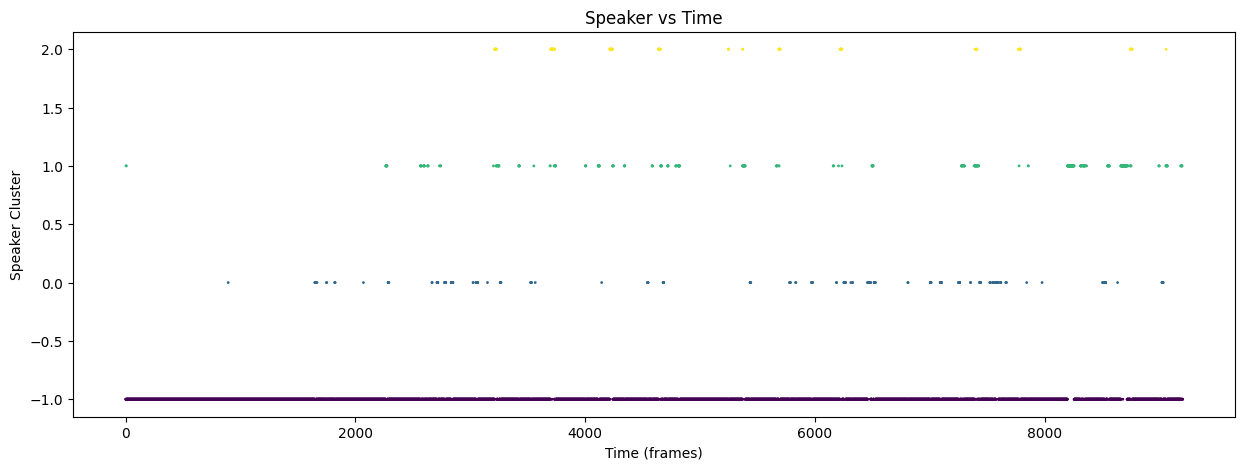

In [51]:
import hdbscan

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_samples=12, min_cluster_size=70)
cluster_labels = clusterer.fit_predict(speaker_embeddings)

# Number of clusters, excluding noise
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise = list(cluster_labels).count(-1)

print(f"Dlusters found: {num_clusters}")
print(f"Noise points: {num_noise}")


plt.figure(figsize=(15, 5))
plt.scatter(range(len(cluster_labels)), cluster_labels, c=cluster_labels, cmap='viridis', s=1)
plt.title('Speaker vs Time')
plt.xlabel('Time (frames)')
plt.ylabel('Speaker Cluster')
plt.show()